# Approach 1: LeNet 
Source: Yan LeCun

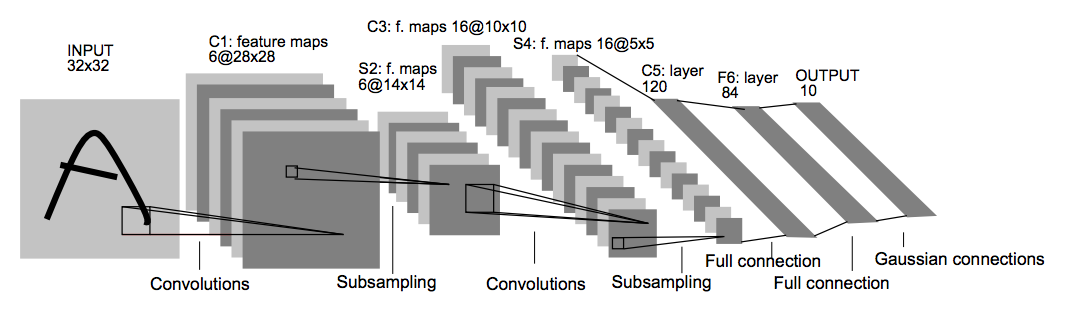

In [1]:
from PIL import Image
Image.open('./lenet.png')

### Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

In [7]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, the data is padded with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

In [8]:
import numpy as np

# Pad images with 0s
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


### Visualize Data

View a sample from the dataset.

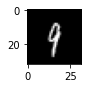

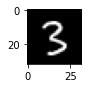

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index1 = random.randint(0, len(X_train))
image1 = X_train[index1].squeeze()

index2 = random.randint(0, len(X_train))
image2 = X_train[index2].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image1, cmap="gray")
plt.figure(figsize=(1,1))
plt.imshow(image2, cmap="gray")

### Preprocess Data

Shuffle the training data.

In [10]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` and `learning rate` values affect the training speed, model accuracy and rate of learning.

In [11]:
import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 100
rate = 0.001

### LENET-5 architecture

In [12]:
import tensorflow as tf
import time
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

lenet_5_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape = X_train[0].shape, padding='same'), # Conv2D layer 1
    tf.keras.layers.AveragePooling2D(), # Sub sampling layer 1
    tf.keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), # Conv2D layer 2
    tf.keras.layers.AveragePooling2D(), # Sub sampling layer 2
    tf.keras.layers.Flatten(), # Flatten
    tf.keras.layers.Dense(120, activation='tanh'), # Fully connected layer
    tf.keras.layers.Dense(84, activation='tanh'), # Fully connected layer
    tf.keras.layers.Dense(10, activation='softmax') # Output layer
])

NAME = 'LeNet-5'

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

checkpoint = ModelCheckpoint(NAME + '.h5',  # model filename
                             monitor='val_loss', # metric to monitor
                             verbose=0,
                             save_best_only= True,
                             mode='auto')

earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0,
                          patience = 4, # Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) # keeps the best weights once stopped

callbacks = [earlystop, checkpoint]

lenet_5_model.compile(optimizer, loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ["acc"])

start = time.time()

history = lenet_5_model.fit(X_train, y_train, epochs=EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks, validation_data=(X_validation, y_validation))

end = time.time()

lenet_5_model.save(NAME + '.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 20s 364us/sample - loss: 0.3165 - acc: 0.9077 - val_loss: 0.1330 - val_acc: 0.9616
Epoch 2/30
55000/55000 [==============================] - 17s 318us/sample - loss: 0.1176 - acc: 0.9647 - val_loss: 0.0914 - val_acc: 0.9724
Epoch 3/30
55000/55000 [==============================] - 19s 349us/sample - loss: 0.0775 - acc: 0.9767 - val_loss: 0.0669 - val_acc: 0.9814
Epoch 4/30
55000/55000 [==============================] - 23s 426us/sample - loss: 0.0576 - acc: 0.9824 - val_loss: 0.0521 - val_acc: 0.9838
Epoch 5/30
55000/55000 [==============================] - 19s 354us/sample - loss: 0.0438 - acc: 0.9866 - val_loss: 0.0595 - val_acc: 0.9820
Epoch 6/30
55000/55000 [==============================] - 22s 397us/sample - loss: 0.0357 - acc: 0.9889 - val_loss: 0.0480 - val_acc: 0.9864
Epoch 7/30
55000/55000 [==============================] - 19s 349us/sample - loss: 0.0297 - acc: 0.9909 -

### Time elapsed in training process

In [13]:
print(f'Time taken to train = {end - start} seconds')

Time taken to train = 237.5430166721344 seconds


### Testing the model

In [14]:
metrics_dict = lenet_5_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 131us/sample - loss: 0.0478 - acc: 0.9844


### Test accuracy and loss

In [15]:
print(f'Test accuracy = {metrics_dict[1] * 100}%')
print(f'Test loss = {metrics_dict[0]}')

Test accuracy = 98.43999743461609%
Test loss = 0.04776516199503094


### Confusion matrix

In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn import metrics

y_pred = lenet_5_model.predict(X_test)

confusion = confusion_matrix(y_test, np.argmax(y_pred,axis=1))

confusion

array([[ 970,    0,    0,    1,    0,    1,    4,    0,    3,    1],
       [   0, 1122,    1,    2,    0,    0,    2,    4,    4,    0],
       [   3,    0, 1021,    0,    1,    0,    0,    7,    0,    0],
       [   0,    0,    1, 1004,    0,    0,    0,    2,    3,    0],
       [   0,    1,    2,    2,  959,    0,    3,    2,    0,   13],
       [   2,    0,    0,   15,    0,  870,    3,    1,    0,    1],
       [   2,    2,    1,    1,    6,    3,  942,    0,    1,    0],
       [   1,    0,    6,    3,    0,    0,    0, 1014,    1,    3],
       [   2,    0,    5,    5,    0,    1,    1,    2,  955,    3],
       [   2,    2,    1,    4,    4,    3,    0,    6,    0,  987]])

### Precision and Recall (LeNet-5)

Refer the weighted average in the end for multi-class precision and recall scores

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_recall = metrics.classification_report(y_test, np.argmax(y_pred, axis = 1))
print(precision_recall)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### Plot the graphs

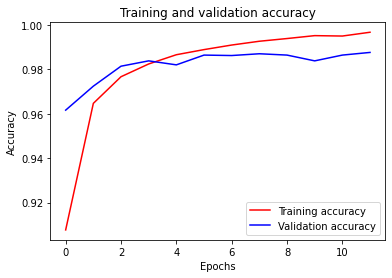

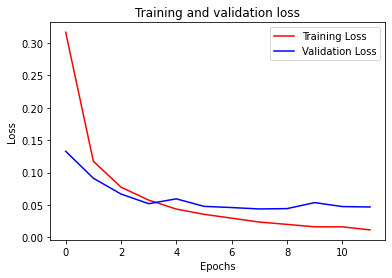

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Approach 2: Traditional neural network

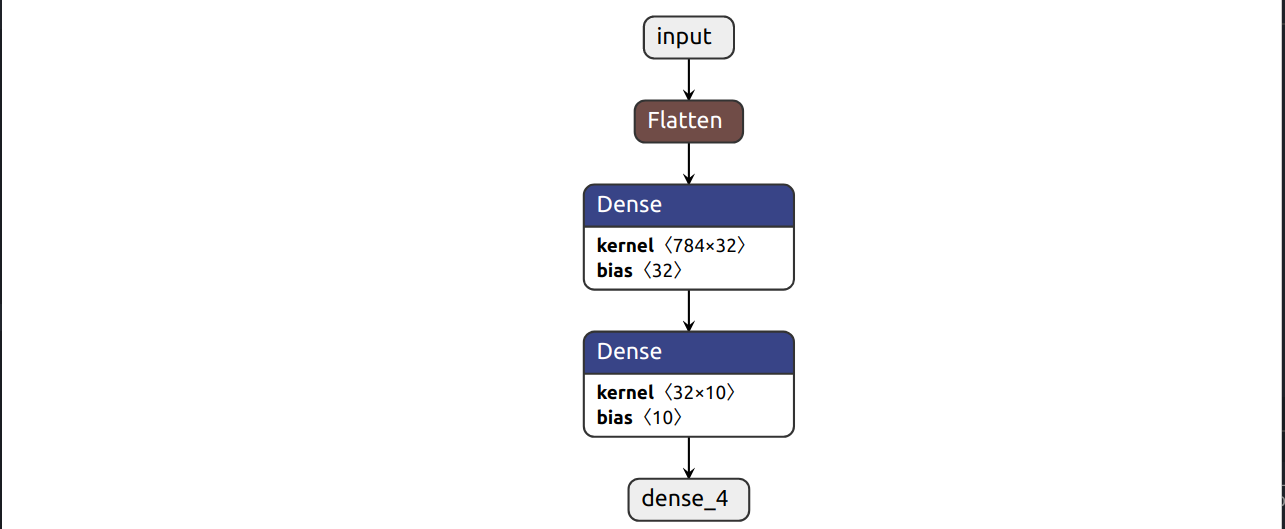

In [2]:
from PIL import Image
Image.open('./ANN.png')

### Load data

Load the MNIST data, which comes pre-loaded with TensorFlow.

In [20]:
mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


### Traditional Neural Network Architecture

In [21]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

ANN_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='tanh'), # Fully connected layer,
    tf.keras.layers.Dense(10, activation='softmax', input_shape = X_train[0].shape) # Output layer
])

NAME = 'ANN'

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

checkpoint = ModelCheckpoint(NAME + '.h5',  # model filename
                             monitor='val_loss', # metric to monitor
                             verbose=0,
                             save_best_only= True,
                             mode='auto')

earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0,
                          patience = 4, # Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) # keeps the best weights once stopped

callbacks = [earlystop, checkpoint]

ANN_model.compile(optimizer, loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ["acc"])

start = time.time()

history = ANN_model.fit(X_train, y_train, epochs=EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks, validation_data=(X_validation, y_validation))

end = time.time()

ANN_model.save(NAME + '.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 1s 18us/sample - loss: 0.5110 - acc: 0.8681 - val_loss: 0.2720 - val_acc: 0.9244
Epoch 2/30
55000/55000 [==============================] - 1s 20us/sample - loss: 0.2546 - acc: 0.9283 - val_loss: 0.2140 - val_acc: 0.9414
Epoch 3/30
55000/55000 [==============================] - 1s 21us/sample - loss: 0.2054 - acc: 0.9417 - val_loss: 0.1813 - val_acc: 0.9522
Epoch 4/30
55000/55000 [==============================] - 1s 19us/sample - loss: 0.1757 - acc: 0.9505 - val_loss: 0.1671 - val_acc: 0.9554
Epoch 5/30
55000/55000 [==============================] - 1s 18us/sample - loss: 0.1550 - acc: 0.9557 - val_loss: 0.1555 - val_acc: 0.9570
Epoch 6/30
55000/55000 [==============================] - 1s 19us/sample - loss: 0.1401 - acc: 0.9601 - val_loss: 0.1435 - val_acc: 0.9586
Epoch 7/30
55000/55000 [==============================] - 1s 19us/sample - loss: 0.1277 - acc: 0.9638 - val_loss: 0.1

### Time elapsed in training process

In [22]:
print(f'Time taken to train = {end - start} seconds')

Time taken to train = 22.29641580581665 seconds


### Testing the model

In [23]:
metrics_dict = ANN_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 25us/sample - loss: 0.1245 - acc: 0.9642


### Test accuracy and loss

In [24]:
print(f'Test accuracy = {metrics_dict[1] * 100}%')
print(f'Test loss = {metrics_dict[0]}')

Test accuracy = 96.42000198364258%
Test loss = 0.1244659258587286


### Confusion matrix

In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn import metrics

y_pred = ANN_model.predict(X_test)

confusion = confusion_matrix(y_test, np.argmax(y_pred,axis=1))

confusion

array([[ 963,    1,    2,    0,    1,    2,    6,    2,    3,    0],
       [   0, 1116,    5,    1,    0,    1,    3,    2,    7,    0],
       [   4,    0,  993,   10,    2,    1,    5,    5,   12,    0],
       [   2,    0,    6,  980,    1,    7,    0,    7,    6,    1],
       [   0,    0,    6,    0,  947,    1,    7,    2,    5,   14],
       [   3,    1,    3,   15,    2,  843,    8,    1,   14,    2],
       [   5,    3,    5,    1,    4,    6,  930,    1,    3,    0],
       [   0,    3,   15,    8,    3,    0,    1,  987,    4,    7],
       [   4,    1,    4,    9,    4,    4,    2,    3,  941,    2],
       [   4,    4,    0,   11,   24,    5,    4,   10,    5,  942]])

### Precision and Recall (ANN)

Refer the weighted average in the end for multi-class precision and recall scores

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_recall = metrics.classification_report(y_test, np.argmax(y_pred, axis = 1))
print(precision_recall)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.97      0.95      0.96       892
           6       0.96      0.97      0.97       958
           7       0.97      0.96      0.96      1028
           8       0.94      0.97      0.95       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



### Plot the graphs

No handles with labels found to put in legend.


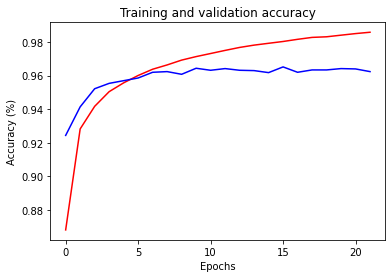

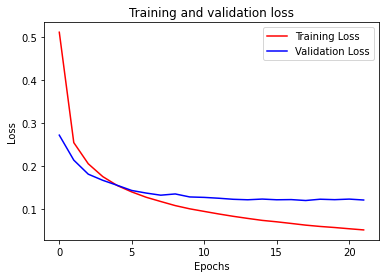

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.figure()
plt.legend()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()